In [1]:
import numpy as np
import jax.numpy as jnp
from skscope import ScopeSolver
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import rbf_kernel

Non-linear feature selection via HSIC-SCOPE
---------------

> Note: ``skscope`` also implemented an api [NonlinearSelection](../../autoapi/skmodel.html#skscope.skmodel.NonlinearSelection) and now users can call it directly. 

### Introduction

In some applications such as  gene selection from microarray data and text mining, we want to find relevant features $X_k$ and the relationship between response $y$ with them are allowed to be non-linear.

Traditional variable selection techniques aiming at detecting the linear dependence can not be applied directly in these cases.
In this example, we introduce a method adapted from [[1]](#refer-1) to identify relevant features $X_k, k\in[p]$ from $X^{n\times p}$ which has nonlinear dependence of $y\in\mathbb{R}^n$.

### Non-linear feature selection: a sparsity-constraint optimization approach

Specifically, we propose the following sparse optimization formulation:
$$\min_{\alpha\in\mathbb{R}^p} \left\|\bar{L}-\sum_{k=1}^p\alpha_k\bar{K}^{(k)}\right\|_F^2,\quad\text{ s.t. } \alpha\geq 0, \|\alpha\|_0\leq s$$
where $\bar{K}^{(k)}=\Gamma K^{(k)}\Gamma\in\mathbb{R}^{n\times n}$, $\bar{L}=\Gamma L\Gamma\in\mathbb{R}^{n\times n}$ are centralized Gram matrices and $\Gamma=I_n-n^{-1}1_n1_n^{\top}\in\mathbb{R}^{n\times n}$.
The matrices $K_{i,j}^{(k)}=K(X_{i,k}, X_{j,k})$, $L_{i,j}=L(y_i, y_j)$ are generated via kernel $K$ and $L$ respectively.
In the following, we choose both $K$ and $L$ to be Gaussian kernel function.

### Intuitive illustration
The above loss function can be understood via its relationship with the Hilbert-Schmidt Independence Criterion (HSCI). We first expand the loss as follows
$$\left\|\bar{L}-\sum_{k=1}^p\alpha_k\bar{K}^{(k)}\right\|_F^2 = \mathrm{HSIC}(y, y) - 2\sum_{k=1}^d\alpha_k \mathrm{HSIC}(X_k, y)+\sum_{k,l=1}^d\alpha_k\alpha_l \mathrm{HSIC}(X_k, X_l)$$
where $\mathrm{HSIC}(X_k, y)=tr(\bar{K}^{(k)}\bar{L})$ is a kernel-based independence measure which takes non-negative values and is zero if and only if two random variables are statistically independent when a universal reproducing kernel such as the Gaussian kernel is used.

From the above expansion, we have the following intuitive illustrations:
- $\mathrm{HSIC}(y, y)$ is a constant and has no impact on the coefficient $\alpha$;
- If $y$ has strong dependence on the $k$-th feature $X_k$, $\mathrm{HSIC}(X_k, y)$ will take a large value and a large coefficient $\alpha_k$ is required to minimize the loss;
- If $y$ is independent of the $k$-th feature $X_k$, $\mathrm{HSIC}(X_k, y)$ will be close to zero and its coefficient $\alpha_k$ tends to be zero under the cardinality constraint $\|\alpha\|_0\leq s$;
- If $X_k$ and $X_l$ are strongly dependent, $\mathrm{HSIC}(X_k, X_l)$ will take a large value and thus either $\alpha_k$ or $\alpha_l$ tends to be zero, this means that redundant features will be excluded;
- Non-negativity constraint $\alpha\geq 0$ is imposed for interpretability, i.e., the value of $\alpha_k$ reflects the degree of dependence between $y$ and $X_k$. 
  
In a word, this loss function has the preferable property to select non-redundant features with strong dependence on $y$. 

### Implemention
Note that ``scope`` can not be directlty used to solve the above optimization due to the presence of the positive constraint $\alpha\geq 0$. Instead, we eliminate this constraint via reparametrization, i.e., we optimize the (component-wise) absolute value of $\alpha$ directly: 
$$\arg\min_{\alpha \in\mathbb{R}^p} \left\|\bar{L}-\sum_{k=1}^p|\alpha_k|\bar{K}^{(k)}\right\|_F^2,\quad\text{ s.t. } \|\alpha\|_0\leq s$$

The following function ``hsic`` shows the code that implements our proposed reparametrization.

In [2]:
def hsic(X, y, sparsity, gamma_x=0.7, gamma_y=0.7):
    n, p = X.shape
    Gamma = np.eye(n) - np.ones((n, 1)) @ np.ones((1, n)) / n
    L = rbf_kernel(y.reshape(-1, 1), gamma=gamma_y)
    L_bar = Gamma @ L @ Gamma
    response = L_bar.reshape(-1)
    K_bar = np.zeros((n**2, p))
    for k in range(p):
        x = X[:, k]
        tmp = rbf_kernel(x.reshape(-1, 1), gamma=gamma_x)
        K_bar[:, k] = (Gamma @ tmp @ Gamma).reshape(-1)
    covariate = K_bar

    def custom_objective(alpha):
        loss = jnp.mean((response - covariate @ jnp.abs(alpha)) ** 2)
        return loss
    
    solver = ScopeSolver(p, sparsity=sparsity)
    alpha = solver.solve(custom_objective)
    return alpha

### Synthetic data example

Two simulation experiments will be performed later to validate its effectiveness.

#### Additive model
First, we consider the following non-linear additive model, that is, the relationship between response $y$ and predictors $X_i$ is non-linear but there exists no interaction among predictors.
In this example, we randomly generate $n=500$ samples and each sample has $p=1000$ predictors. The reponse depends on the first $s=4$ predictors only and the specific relation is depicted as follows:
$$y=-2\sin(2X_{51})+X_{301}^2+X_{451}+\exp(-X_{801})+\epsilon.$$

In [3]:
# data generation
n, p, s = 500, 1000, 4
rng = np.random.default_rng(0)
X = rng.normal(0, 1, (n, p))
noise = rng.normal(0, 1, n)
y = -2 * np.sin(2 * X[:, 50]) + X[:, 300] ** 2 + X[:, 450] + np.exp(- X[:, 800]) + noise
support_true = np.array([50, 300, 450, 800])

To illustrate the non-linear relationship, we visualize the marginal relationship between the response $y$ and these $4$ relevant predictors $X_i$'s respectively.
The corresponding scatter plots is shown and $4$ polynomial regressions are fit to indicate the non-linear effects.

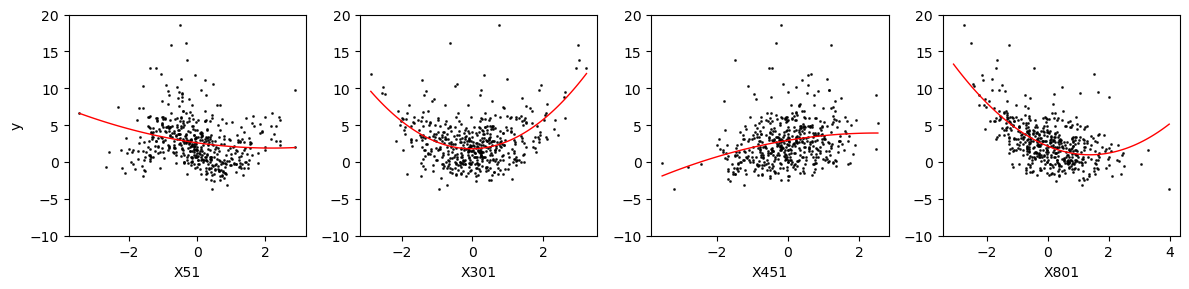

In [4]:
# marginal relation plot
fig, axes = plt.subplots(1, 4, figsize=(12,3))
for i in range(len(axes)):
    sns.regplot(x=X[:, support_true[i]], y=y, order=2, ci=None, ax=axes[i],
                scatter_kws={'color': 'k', 's': 1},
                line_kws={'linewidth': 1, 'color': 'r'})
    axes[i].set_ylim(-10, 20)
    axes[i].set_xlabel('X{}'.format(support_true[i]+1))
axes[0].set_ylabel('y')
plt.tight_layout()


The following result shows that ``scope`` can exactly select the relevant predictors in this setting.

In [5]:
# variable selection
alpha = hsic(X, y, s)
support_hsic = np.nonzero(alpha)[0]
support_hsic

array([ 50, 300, 450, 800])

We next implement the linear model based variable-selection approach.

In [6]:
def linear_splicing(X, y, sparsity):
    n, p = X.shape

    def linear_loss(params):
        loss = jnp.mean((y - X @ params)**2)
        return loss
    
    solver = ScopeSolver(p, sparsity=sparsity)
    params = solver.solve(linear_loss)
    return np.nonzero(params)[0]
support_linear = linear_splicing(X, y, s)

Comparison with linear splicing and selected variables are shown in the following figure. Note that the x-axis shows the indexes of $1000$ variables and the y-axis show the binary value that whether a specified index is selected.

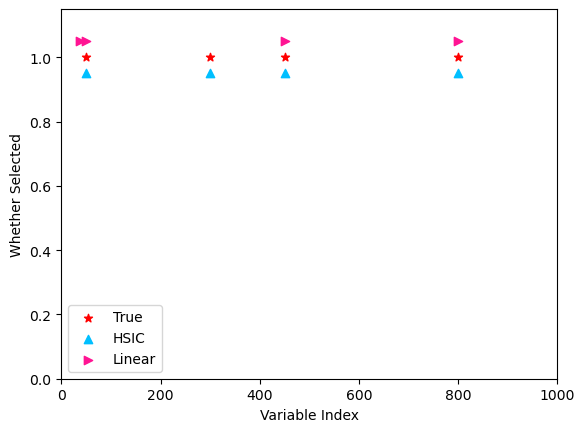

In [7]:
# To avoid the overlap of markers, we modify some values of 1 slightly to 0.95 and 1.05.
plt.scatter(support_true, np.ones(len(support_true)), color='red', marker='*', label='True')
plt.scatter(support_hsic, 0.95*np.ones(len(support_hsic)), color='deepskyblue', marker='^', label='HSIC')
plt.scatter(support_linear, 1.05*np.ones(len(support_linear)), color='deeppink', marker='>', label='Linear')


plt.xlim(0, 1000)
plt.ylim(0, 1.15)
plt.xlabel('Variable Index')
plt.ylabel('Whether Selected')
plt.legend()

plt.show()

From the above figure, we see that all variables are selected correctly by the proposed HSIC-splicing method while the variable $X_{301}$ is missed by the linear splicing method. This may be caused by the qudratic form $X_{301}^2$ (compared to other 3 nonlinear trasformation) which imposes the weakest linear denepndence between $y$ and $X_{301}$ within the range of $X_{301}$, see the above scatter plot.

#### Non-additive model 
Beyond the additive model, we here allow interaction effects among features (e.g. between $X_{51}$ and $X_{301}$) specified as follows:
$$y=X_{51}\exp(2X_{301})+X_{801}^2+\epsilon.$$

Similarly, we set $n=500, p=1000$ but only $s=3$ relevant predictors are included in the model.

In [8]:
# data generation
n, p, s = 500, 1000, 3
rng = np.random.default_rng(00)
X = rng.normal(0, 1, (n, p))
noise = rng.normal(0, 1, n)
y = X[:, 50] * np.exp(2 * X[:, 300]) + X[:, 800] ** 2 + noise
support_true = np.array([50, 300, 800])

The following figure shows the marginal relationship betweeen $y$ and these three relevant predictors $X_i$'s.

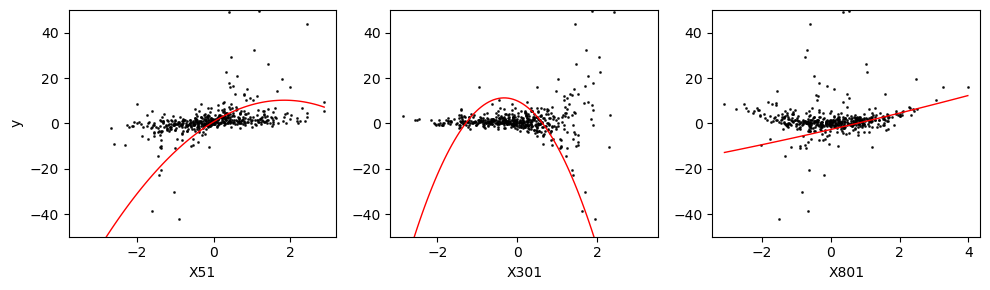

In [9]:
# marginal relation plot
fig, axes = plt.subplots(1, 3, figsize=(10,3))
for i in range(len(axes)):
    sns.regplot(x=X[:, support_true[i]], y=y, order=2, ci=None, ax=axes[i],
                scatter_kws={'color': 'k', 's': 1},
                line_kws={'linewidth': 1, 'color': 'r'})
    axes[i].set_ylim(-50, 50)
    axes[i].set_xlabel('X{}'.format(support_true[i]+1))
axes[0].set_ylabel('y')    
plt.tight_layout()

Despite of the interaction between $X_1$ and $X_2$, ``scope`` still correctly selects the true relevant predictors.

In [10]:
# variable selection
alpha = hsic(X, y, s)
support_hsic = np.nonzero(alpha)[0]
support_hsic

array([ 50, 300, 800])

Comparison with linear splicing (similar as above).

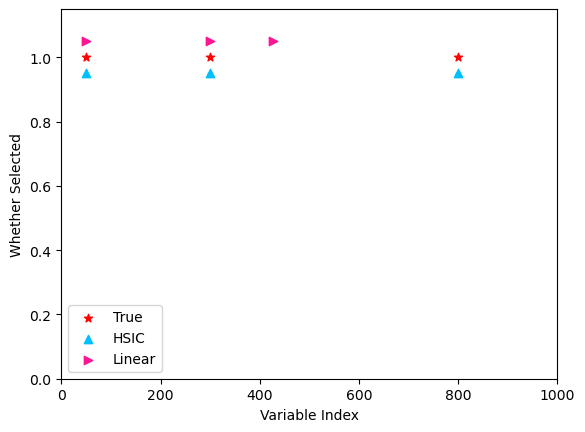

In [11]:
support_linear = linear_splicing(X, y, s)

# To avoid the overlap of markers, we modify some values of 1 slightly to 0.95 and 1.05.
plt.scatter(support_true, np.ones(len(support_true)), color='red', marker='*', label='True')
plt.scatter(support_hsic, 0.95*np.ones(len(support_hsic)), color='deepskyblue', marker='^', label='HSIC')
plt.scatter(support_linear, 1.05*np.ones(len(support_linear)), color='deeppink', marker='>', label='Linear')

plt.xlim(0, 1000)
plt.ylim(0, 1.15)
plt.xlabel('Variable Index')
plt.ylabel('Whether Selected')
plt.legend()

plt.show()

Similar to the additive case, the quadratic form $X_{801}^2$ is missed by the linear splicing method due to the weak linear dependence.

### Reference

<div id="refer-1"></div>

- [1] Yamada M, Jitkrittum W, Sigal L, et al. High-dimensional feature selection by feature-wise kernelized lasso[J]. Neural computation, 2014, 26(1): 185-207.